### Importy

In [1]:
pip install shap timeshap ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=ae8af84539daddf151278815db7e78cba2aabb9ded88b20f5aaf04983adac890
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv1D, InputLayer
from keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import itertools
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import shap
from scripts.train_utilities import *
from scripts.essentials import *
from scripts.plots import *
from keras.models import load_model

In [3]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
train_set = pd.read_csv('train_set_full.csv')
test_set = pd.read_csv('test_set_full.csv')
val_set = pd.read_csv('val_set_full.csv')

In [5]:
prefix = "BTC-USD"

### Funkcje

In [6]:
def create_unique_subsets(columns, subset_size=5, min_diff=2):
    """
    Create subsets of columns where each subset differs from every other subset by at least 'min_diff' columns.

    :param columns: List of all columns.
    :param subset_size: The size of each subset.
    :param min_diff: Minimum number of different columns between any two subsets.
    :return: A list of unique subsets.
    """
    all_combinations = list(itertools.combinations(columns, subset_size))
    unique_subsets = []

    for combo in all_combinations:
        if all(len(set(combo) - set(subset)) >= min_diff for subset in unique_subsets):
            unique_subsets.append(combo)

    return unique_subsets

def make_model_better(X, y, X_val, y_val, n_epochs, lstm_units=64, dense_units=10, patience=5):
    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1], X.shape[2])))

    # LSTM layers
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))

    # Dense layers
    model.add(Dense(units=dense_units))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping and model checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(X, y, epochs=n_epochs, validation_data=(X_val, y_val), callbacks=[early_stopping, model_checkpoint])

    return model, history

# Example usage:
# model, history = make_model(X_train, y_train, X_val, y_val, n_epochs=50, lstm_units=64, dense_units=10, patience=5)

def window_dataset(df, target_column, window_size):
    X = []
    y = []

    # Iterate over the dataset
    for i in range(len(df) - window_size):
        # Extract the window of data
        window = df[i:i+window_size]

        # Extract the features (X) and target (y)
        X.append(window.drop(columns=[target_column]).values)
        y.append(df[target_column][i+window_size])

    return np.array(X), np.array(y)

def run_multiple_models(train_set,val_set,cols_subset,n_epochs=100):

  window_size = 14
  target_cols = ['target_7']
  mse_val = []
  mse_train = []
  aggregated_shap = []
  for idx,cols_used in enumerate(cols_subset):
    print('-------------------------------')
    print(idx)

    X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
    X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)

    model,history = make_model(X,y, X_val, y_val, n_epochs)

    mse_val.append(min(history.history['val_loss']))
    mse_train.append(min(history.history['loss']))

    explainer = shap.DeepExplainer(model, X)
    shap_values = explainer.shap_values(X_val)

    aggregated_shap.append(np.mean(np.abs(shap_values[0]), axis=0))

    #create df
    if (idx%15 == 0):
      df = pd.DataFrame({'cols_used': cols_subset[:idx+1], 'mse_val': mse_val, 'mse_train': mse_train,
                        'aggregated_shap':aggregated_shap})
      df.to_csv('df_shap'+str(idx)+'.csv')
  df = pd.DataFrame({'cols_used': cols_subset, 'mse_val': mse_val, 'mse_train': mse_train,
                        'aggregated_shap':aggregated_shap})
  df.to_csv('df_shap_final.csv')

  return df

def parse_cols_used(cols_string):
    """
    Parses the column names used in the model from the string representation.

    Args:
    cols_string (str): A string representing the tuple of column names.

    Returns:
    list: A list of column names.
    """
    # Remove the outer brackets and split the string into column names
    cols = cols_string.strip("()").split(", ")
    # Remove quotes and extra characters from column names
    cleaned_cols = [col.strip("'") for col in cols]
    return cleaned_cols

def parse_shap_values(shap_string):
    """
    Parses a string representation of a list of lists of SHAP values into a Python list of lists.

    Args:
    shap_string (str): A string representing a list of lists of SHAP values.

    Returns:
    list of lists: A list of lists of SHAP values.
    """
    # Remove the outer brackets and split the string into rows, handling newline characters
    rows = shap_string.strip('[]').split('\n')

    # Parse each row into a list of floats
    parsed_rows = [list(map(float, row.strip(' []').split())) for row in rows]

    return parsed_rows

def make_model(X, y, X_val, y_val, n_epochs, lstm_units=32,dense_units=8):
    tf.keras.backend.clear_session()

    model = Sequential()
    model.add(InputLayer(input_shape=(X.shape[1], X.shape[2])))

    # LSTM layers
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))

    # Dense layers
    model.add(Dense(units=dense_units))
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Early stopping and model checkpoint

    # Train the model
    history = model.fit(X, y, epochs=n_epochs, validation_data=(X_val, y_val),
                        verbose=0)

    return model, history

def plot_mean_feature_importance(shap_values, feature_names,max_=False):
    """
    Plot the mean importance of each feature across all time steps.

    :param shap_values: A 3D array of SHAP values with shape (samples, window_size, num_features).
    :param feature_names: List of feature names.
    """
    if max_:
    # Aggregate SHAP values across all samples and time steps
      aggregated_shap = np.max(np.abs(shap_values), axis=(0))
    else:
      aggregated_shap = np.mean(np.abs(shap_values), axis=(0))


    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, aggregated_shap)
    plt.title('Mean Feature Importance Across All Time Steps')
    plt.ylabel('Mean SHAP Value')
    plt.xlabel('Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Zmienne

Newsy

In [ ]:
train_set.columns

Index(['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', '^GSPC_Close',
       'EURUSD=X_Close', 'BTC-USD_Open', 'BTC-USD_High', 'BTC-USD_Low',
       'BTC-USD_Close', 'mean_future', 'mean_influential', 'mean_trustworthy',
       'mean_clickbait', 'norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14',
       'vwap_14', 'norm_roc_14', 'log_return_1', 'log_return_7',
       'log_return_14', 'log_return_28', 'log_return_gspc_1',
       'log_return_gspc_7', 'log_return_gspc_14', 'log_return_gspc_28',
       'target_1', 'target_7', 'target_14', 'target_28', 'minmax_^GSPC_Volume',
       'minmax_BTC-USD_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressu

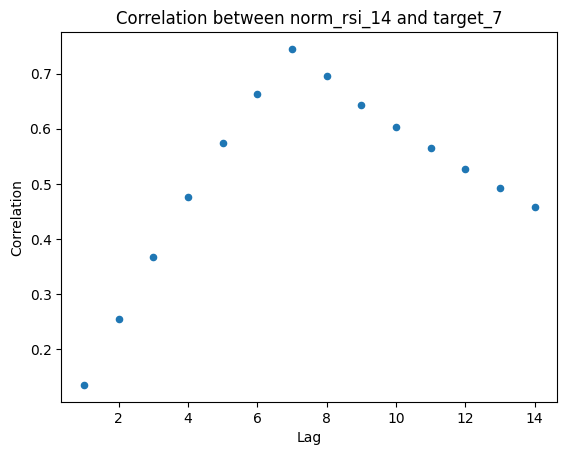

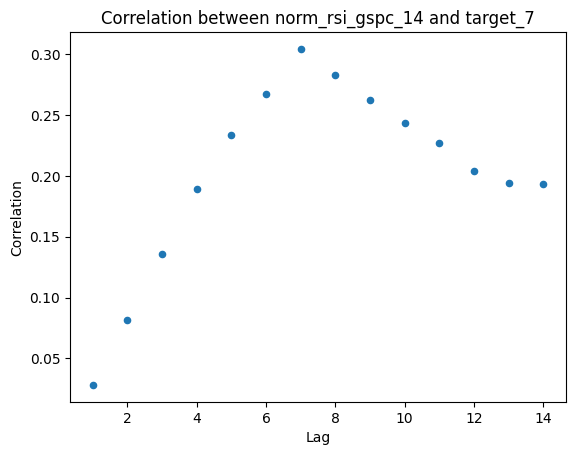

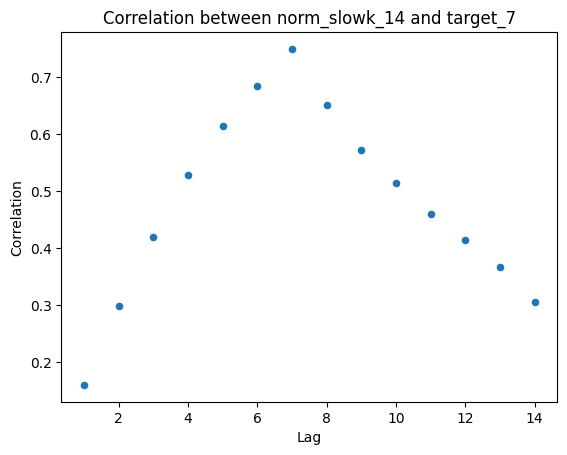

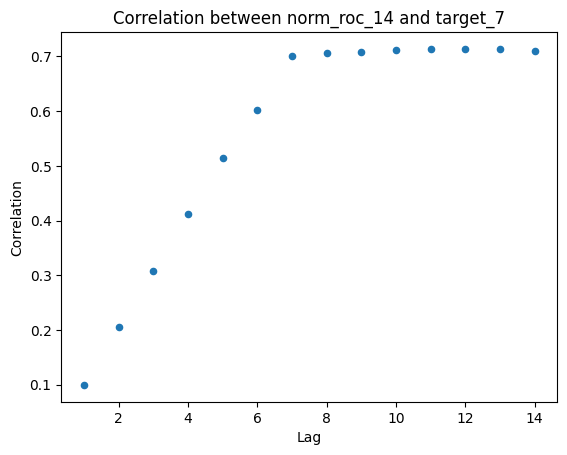

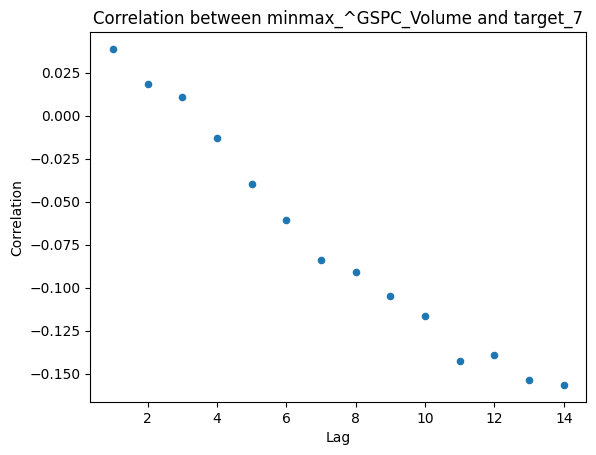

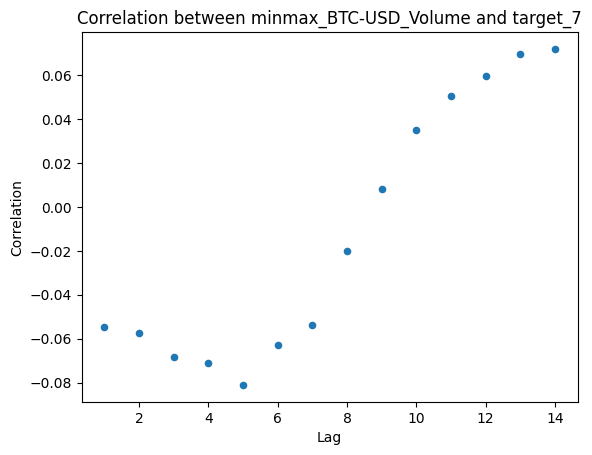

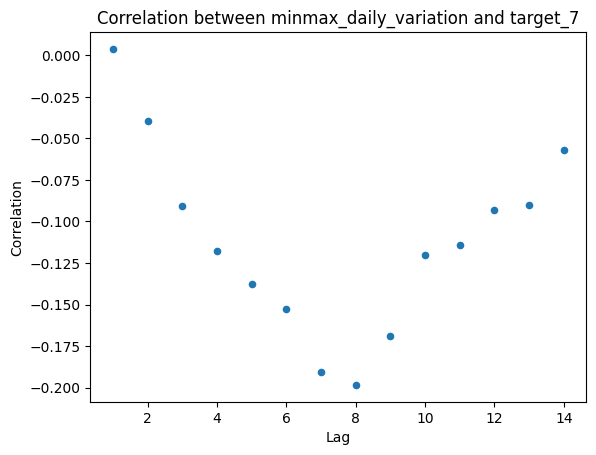

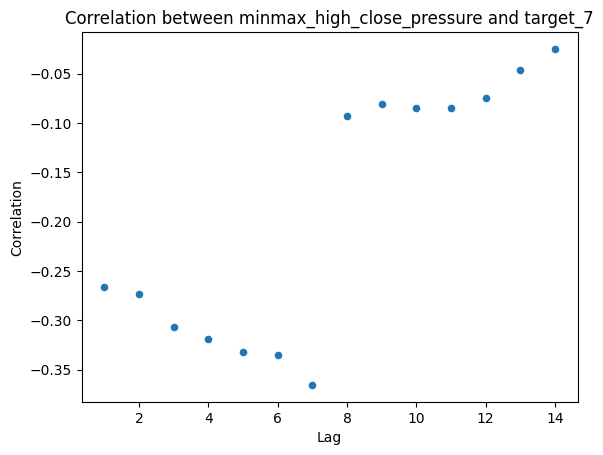

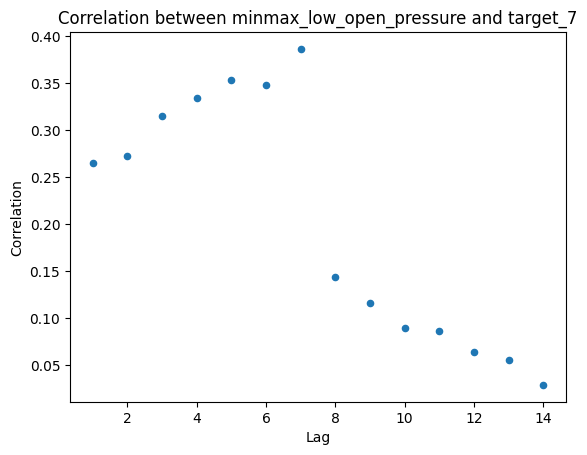

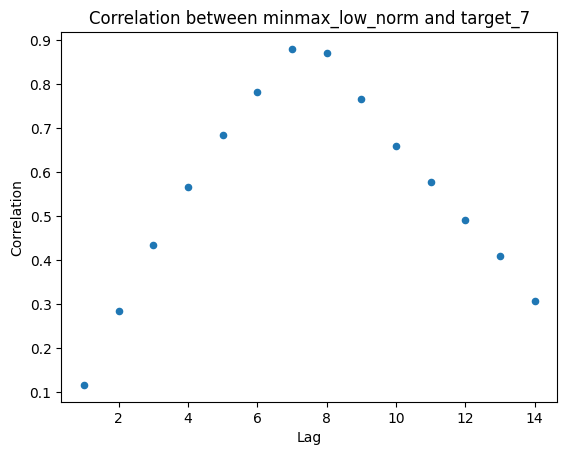

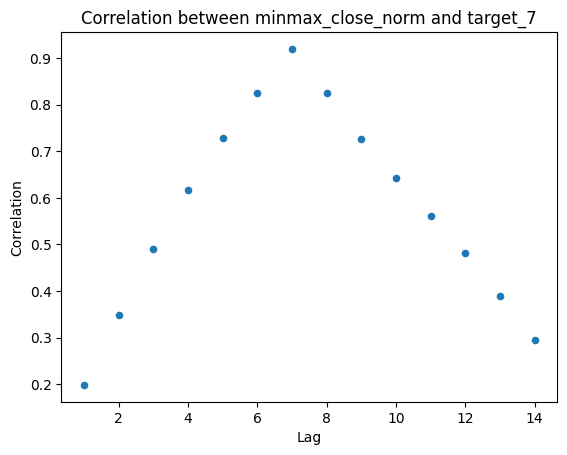

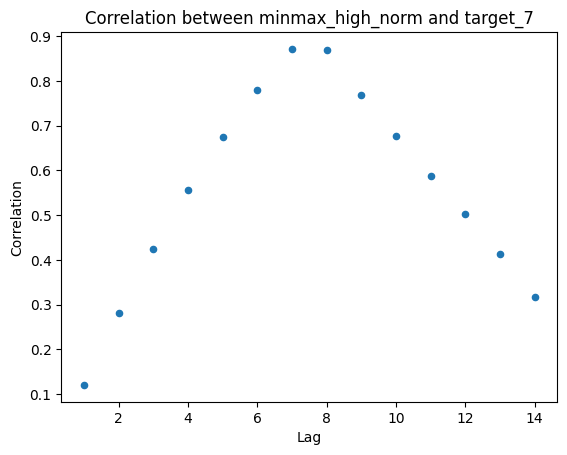

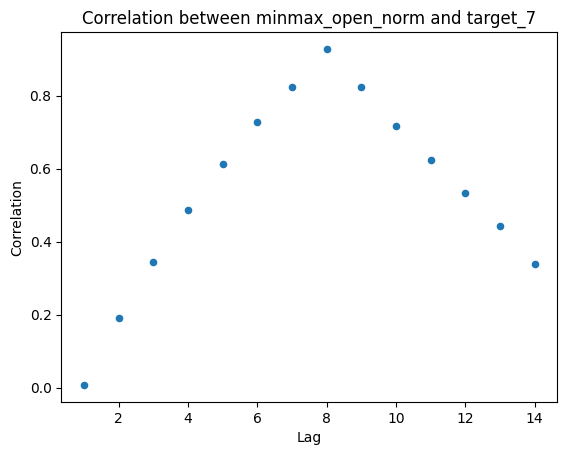

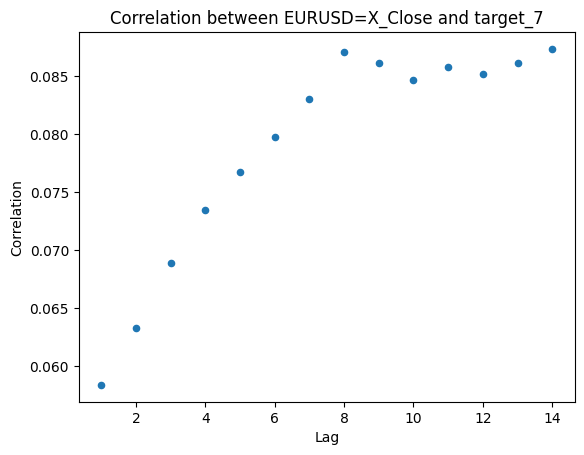

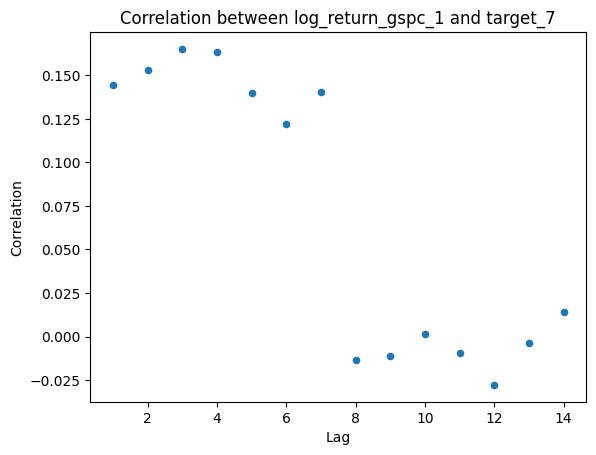

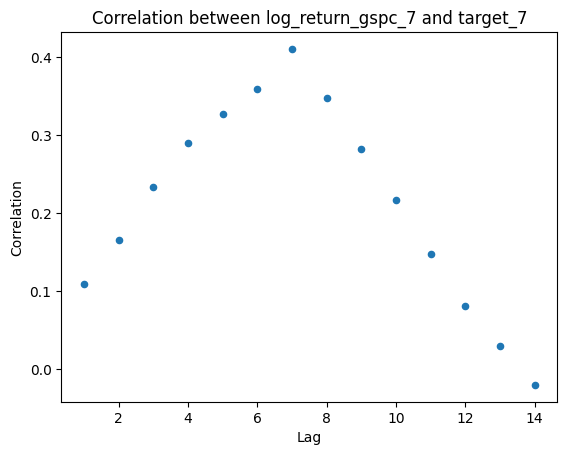

In [ ]:
plot_lagged_correlations(train_set[['norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'norm_roc_14',
        'minmax_^GSPC_Volume', 'minmax_BTC-USD_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressure', 'minmax_low_open_pressure',
       'minmax_low_norm', 'minmax_close_norm', 'minmax_high_norm',
       'minmax_open_norm', 'EURUSD=X_Close', 'log_return_gspc_1' ,'log_return_gspc_7','target_7']], 'target_7')

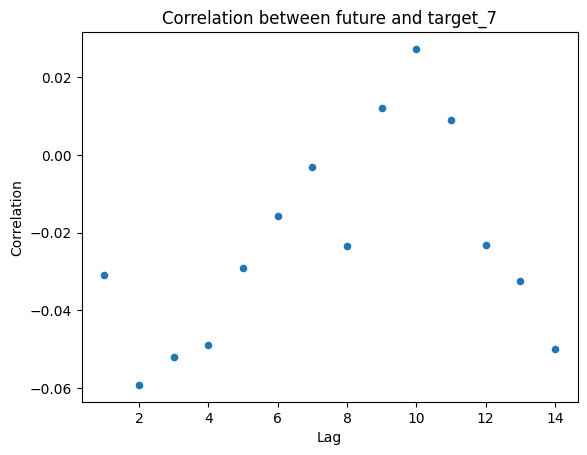

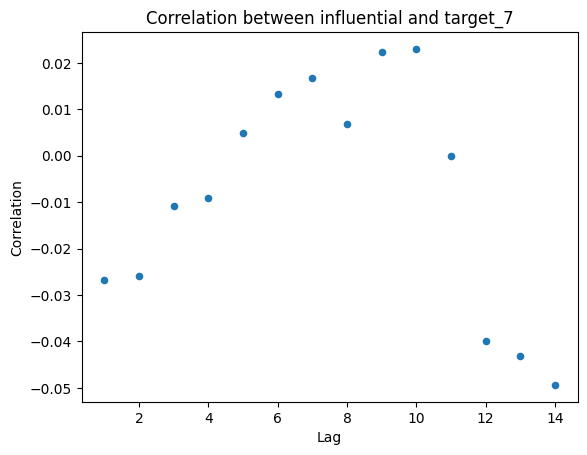

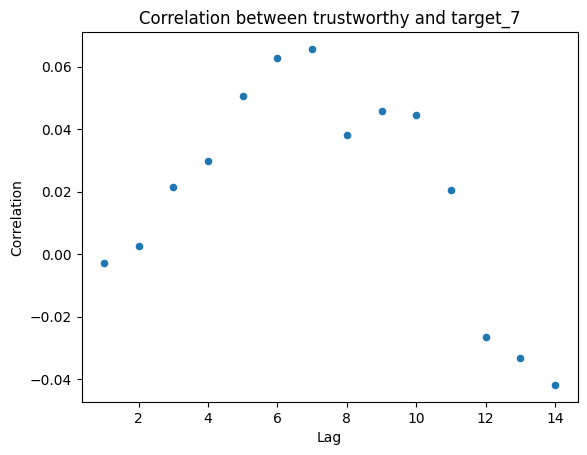

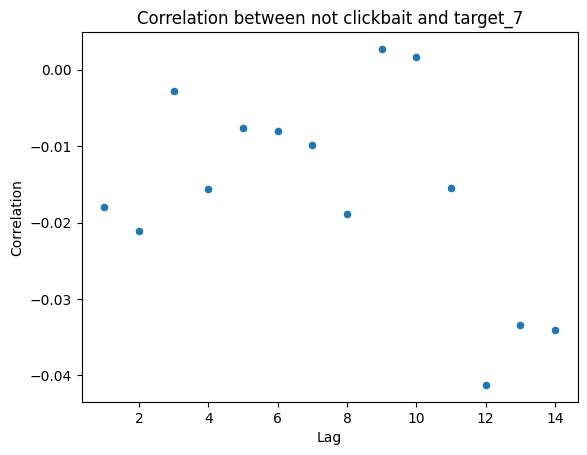

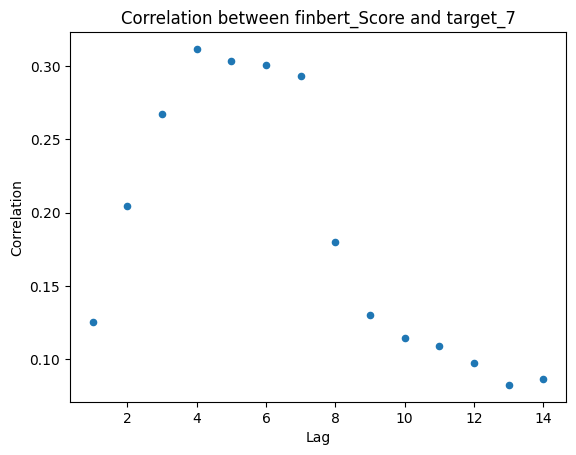

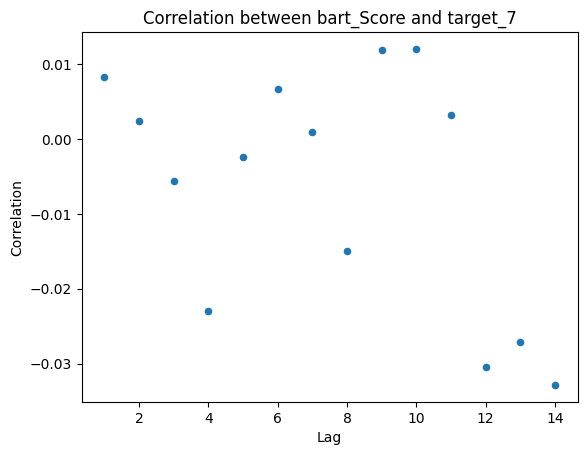

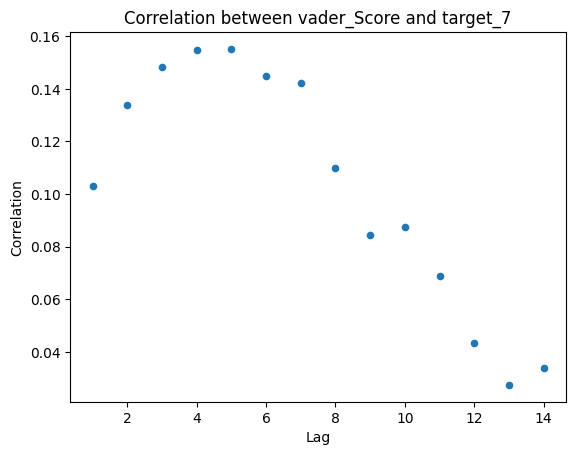

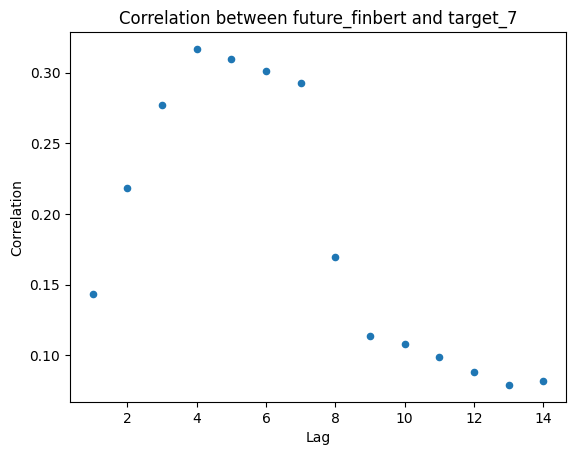

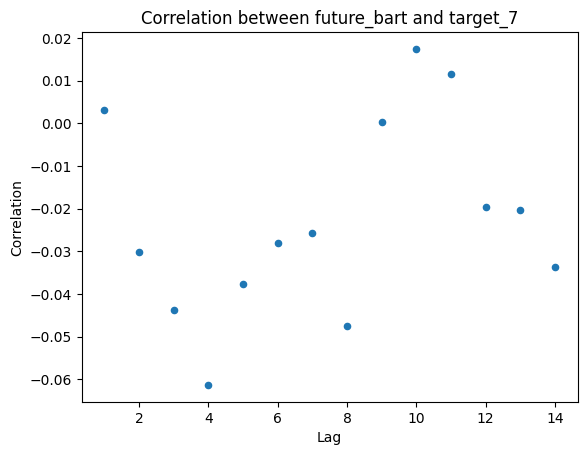

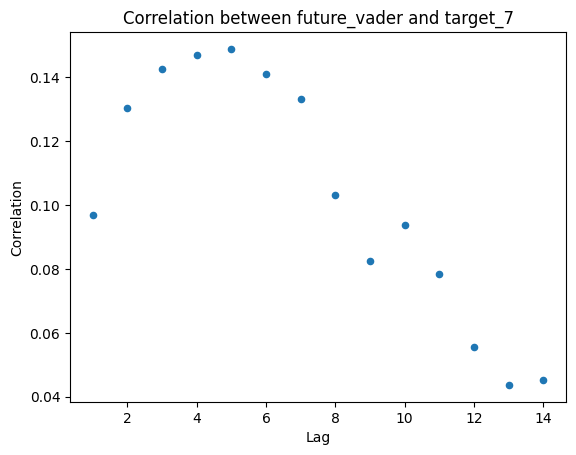

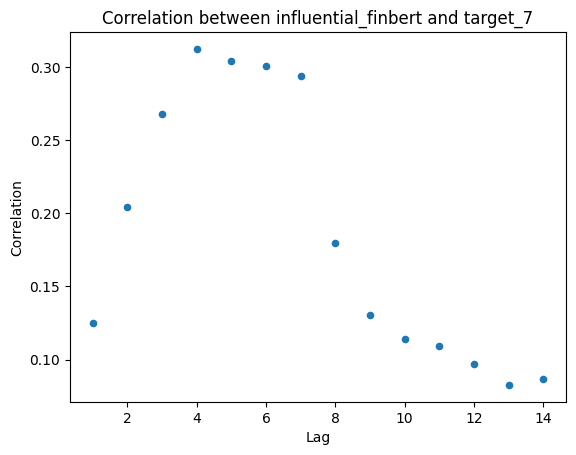

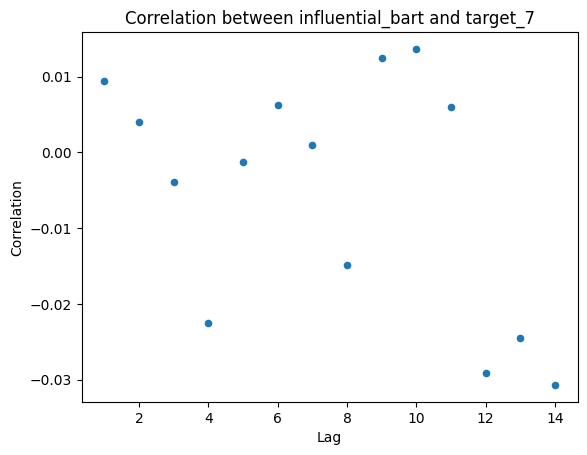

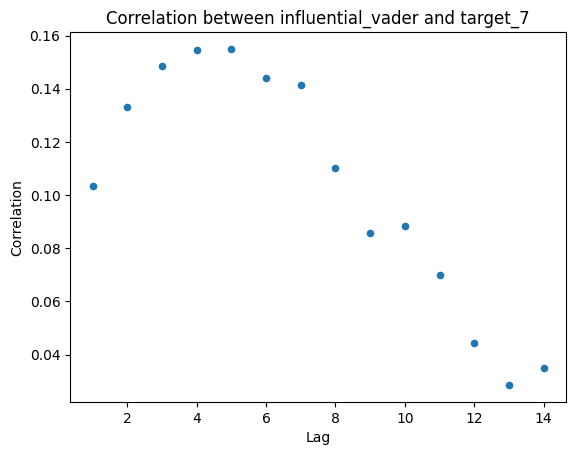

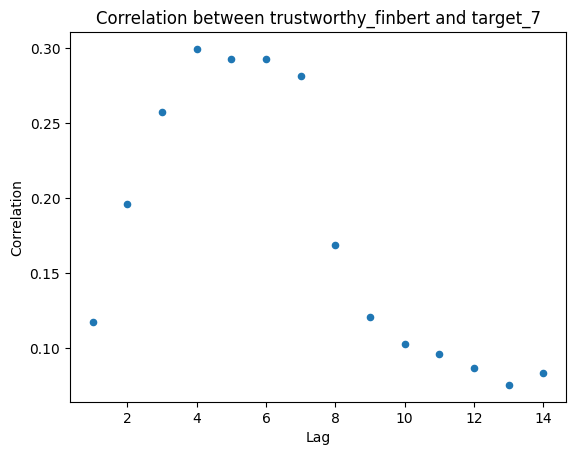

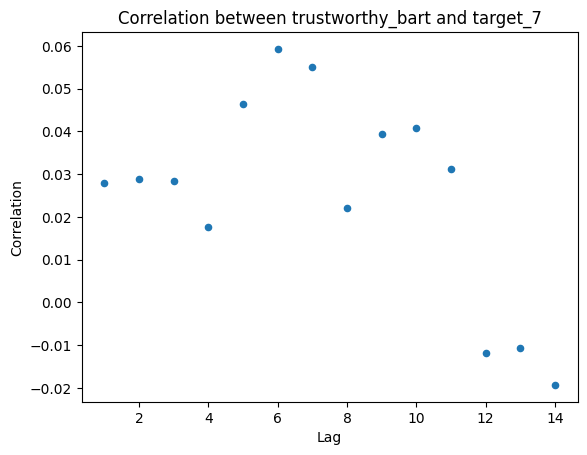

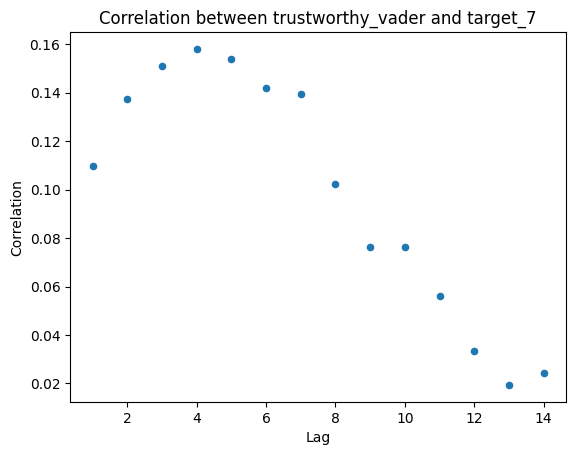

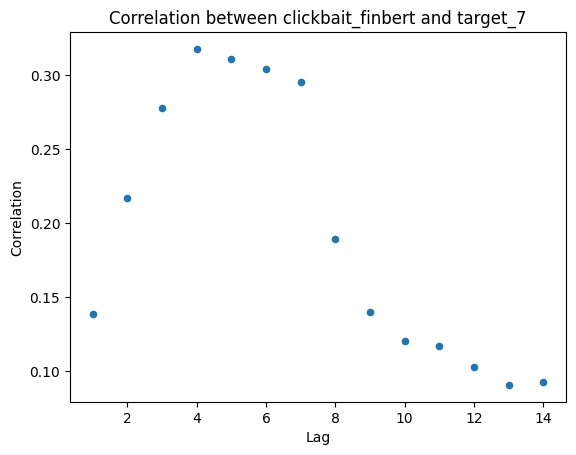

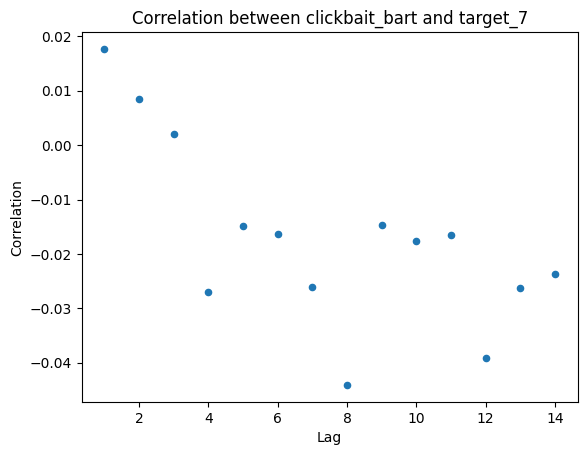

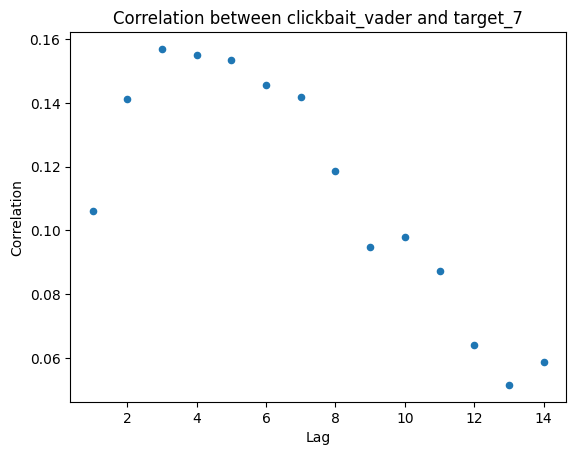

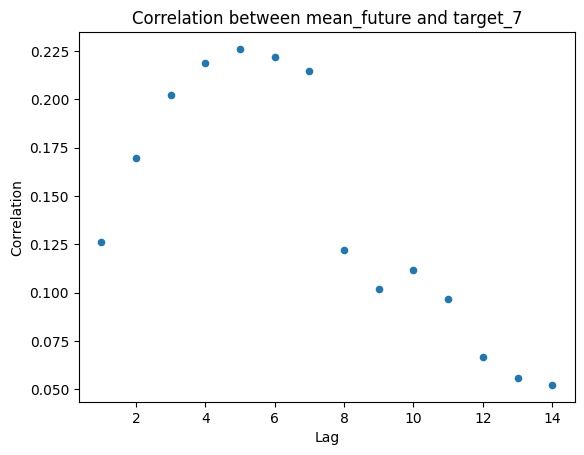

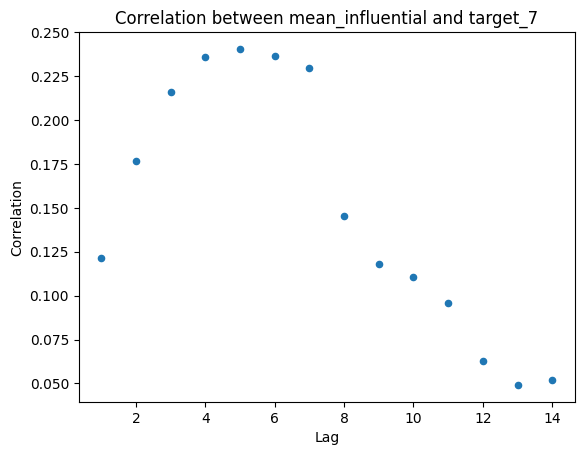

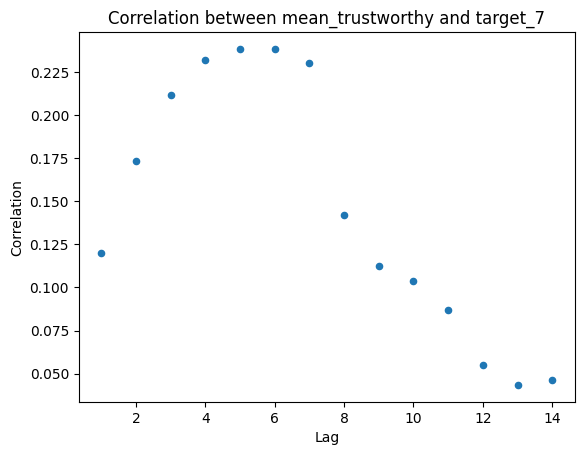

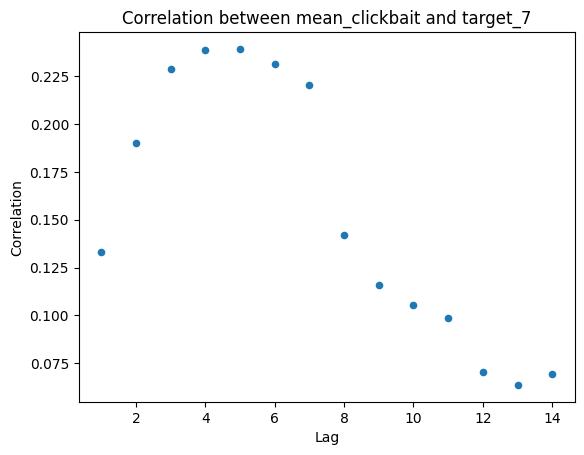

In [ ]:
plot_lagged_correlations(train_set[['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader','mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait','target_7']], 'target_7')

### Shap dla prostych LSTM - szukanie globalnej wagi kolumn

In [7]:
cols = ['finbert_Score', 'bart_Score', 'vader_Score',
        'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
        'norm_rsi_14', 'norm_rsi_gspc_14',
        'norm_slowk_14', 'norm_roc_14',
        'minmax_BTC-USD_Volume','log_return_7','log_return_1','EURUSD=X_Close',
        'minmax_daily_variation', 'minmax_high_close_pressure',
        'minmax_low_open_pressure',
        'minmax_low_norm', 'minmax_close_norm',
        'minmax_high_norm', 'minmax_open_norm']

u = create_unique_subsets(cols, subset_size=5, min_diff=3)

In [8]:
shift_ = 5
window_size = 14
target_cols = ['target_7']
y_base_val = val_set[target_cols[0]].shift(shift_)[window_size:].values
y_base_train = train_set[target_cols[0]].shift(shift_)[window_size:].values
y_base0_val = [0 for i in range((val_set.shape[0]-window_size))]
y_base0_train = [0 for i in range((train_set.shape[0]-window_size))]

In [9]:
len(u)

97

In [ ]:
df = run_multiple_models(train_set,val_set,u,n_epochs=200)

In [51]:
df.to_csv("df_shap_BTC-USD.csv")

In [47]:
df = pd.read_csv("/content/df_shap45_0.csv")
df['cols_used'] = df['cols_used'].apply(parse_cols_used)
df['aggregated_shap'] = df['aggregated_shap'].apply(parse_shap_values)

# top_10_df = df.nsmallest(10, 'mse_val')

In [52]:
top_10_df = df.nsmallest(10, 'mse_val')

In [56]:
top_10_df

,cols_used,mse_val,mse_train,aggregated_shap
45,"[norm_rsi_gspc_14, norm_slowk_14, minmax_BTC-U...",0.000645,0.001348,"[[0.00582128, 0.00380193, 0.00846792, 0.000281..."
1,"[vader_Score, mean_future, norm_rsi_14, norm_r...",0.000701,0.001017,"[[0.00536672, 0.00372176, 0.01120727, 0.007276..."
59,"[finbert_Score, vader_Score, norm_rsi_14, norm...",0.000774,0.000540,"[[0.00539655, 0.0045566, 0.00128891, 0.0037208..."
29,"[mean_influential, log_return_1, EURUSD=X_Clos...",0.000810,0.001169,"[[0.00427287, 0.00080875, 0.00057593, 0.002848..."
42,"[norm_rsi_14, minmax_BTC-USD_Volume, log_retur...",0.000814,0.004585,"[[0.00578563, 0.00651123, 0.00075374, 0.003843..."
75,"[finbert_Score, norm_rsi_14, norm_slowk_14, EU...",0.000818,0.000796,"[[0.00796324, 0.00449276, 0.0088968, 0.0007117..."
64,"[finbert_Score, mean_future, norm_rsi_14, minm...",0.000837,0.001512,"[[0.00738514, 0.0044496, 0.00539009, 0.0078977..."
56,"[finbert_Score, bart_Score, minmax_low_open_pr...",0.000848,0.000801,"[[0.00566224, 0.00309635, 0.00173885, 0.001121..."
73,"[finbert_Score, mean_trustworthy, minmax_high_...",0.000852,0.001000,"[[0.00532501, 0.00359332, 0.00345942, 0.001713..."
61,"[finbert_Score, vader_Score, minmax_daily_vari...",0.000857,0.000516,"[[0.00525957, 0.0052102, 0.0022666, 0.0002566,..."


In [54]:
column_importance_sum_count = {}

for index, row in top_10_df.iterrows():

    shap_values = row['aggregated_shap']
    cols = row['cols_used']
    mean_shap = np.mean(shap_values, axis=0)

    # Update the sum and count of mean SHAP values for each column
    for col, value in zip(cols, mean_shap):
        if col in column_importance_sum_count:
            column_importance_sum_count[col]['sum'] += value
            column_importance_sum_count[col]['count'] += 1
        else:
            column_importance_sum_count[col] = {'sum': value, 'count': 1}

# Calculate the mean importance for each column
column_importance_mean = {col: (val['sum'] / val['count'] , val['count']) for col, val in column_importance_sum_count.items()}

# Sort the column importance dictionary for better readability
sorted_column_importance_mean = dict(sorted(column_importance_mean.items(), key=lambda item: item[1], reverse=True))

sorted_column_importance_mean

{'finbert_Score': (0.008206609761904762, 6),
 'mean_influential': (0.008039172142857142, 1),
 'vader_Score': (0.0053636880952380945, 3),
 'minmax_BTC-USD_Volume': (0.005349995, 3),
 'norm_slowk_14': (0.005209961428571428, 3),
 'mean_trustworthy': (0.004307988571428572, 1),
 'bart_Score': (0.004182629285714286, 1),
 'norm_rsi_gspc_14': (0.004072536071428571, 2),
 'mean_future': (0.0038229303571428574, 2),
 'norm_rsi_14': (0.0037592661428571426, 5),
 'norm_roc_14': (0.003714747142857143, 1),
 'minmax_daily_variation': (0.003474967142857143, 3),
 'minmax_high_close_pressure': (0.003353532857142857, 1),
 'minmax_open_norm': (0.0018122385714285712, 3),
 'minmax_close_norm': (0.0016711953571428573, 2),
 'minmax_low_norm': (0.0015157137500000002, 4),
 'minmax_low_open_pressure': (0.0012262302380952382, 3),
 'log_return_1': (0.0008933747619047618, 3),
 'EURUSD=X_Close': (0.0004947295238095238, 3)}

In [55]:
column_importance_sum_count = {}

for index, row in top_10_df.iterrows():
    shap_values = row['aggregated_shap']
    cols = row['cols_used']
    mean_shap = np.max(shap_values, axis=0)

    # Update the sum and count of mean SHAP values for each column
    for col, value in zip(cols, mean_shap):
        if col in column_importance_sum_count:
            column_importance_sum_count[col]['sum'] += value
            column_importance_sum_count[col]['count'] += 1
        else:
            column_importance_sum_count[col] = {'sum': value, 'count': 1}

# Calculate the mean importance for each column
column_importance_mean = {col: (val['sum'] / val['count'] , val['count']) for col, val in column_importance_sum_count.items()}

# Sort the column importance dictionary for better readability
sorted_column_importance_mean = dict(sorted(column_importance_mean.items(), key=lambda item: item[1], reverse=True))

sorted_column_importance_mean

{'mean_influential': (0.01216345, 1),
 'finbert_Score': (0.011493721666666666, 6),
 'minmax_BTC-USD_Volume': (0.010505613333333332, 3),
 'vader_Score': (0.00835165, 3),
 'norm_slowk_14': (0.007888876666666668, 3),
 'bart_Score': (0.00765886, 1),
 'minmax_daily_variation': (0.007246239999999998, 3),
 'norm_rsi_14': (0.006556123999999999, 5),
 'norm_rsi_gspc_14': (0.00654906, 2),
 'mean_trustworthy': (0.00644845, 1),
 'mean_future': (0.005750485, 2),
 'norm_roc_14': (0.00477033, 1),
 'minmax_high_close_pressure': (0.00426422, 1),
 'minmax_close_norm': (0.002963355, 2),
 'minmax_open_norm': (0.0027037433333333334, 3),
 'minmax_low_open_pressure': (0.0025280800000000003, 3),
 'minmax_low_norm': (0.0022360125, 4),
 'log_return_1': (0.0015793633333333335, 3),
 'EURUSD=X_Close': (0.0007158366666666667, 3)}

### TOP 10 modeli SHAP


45


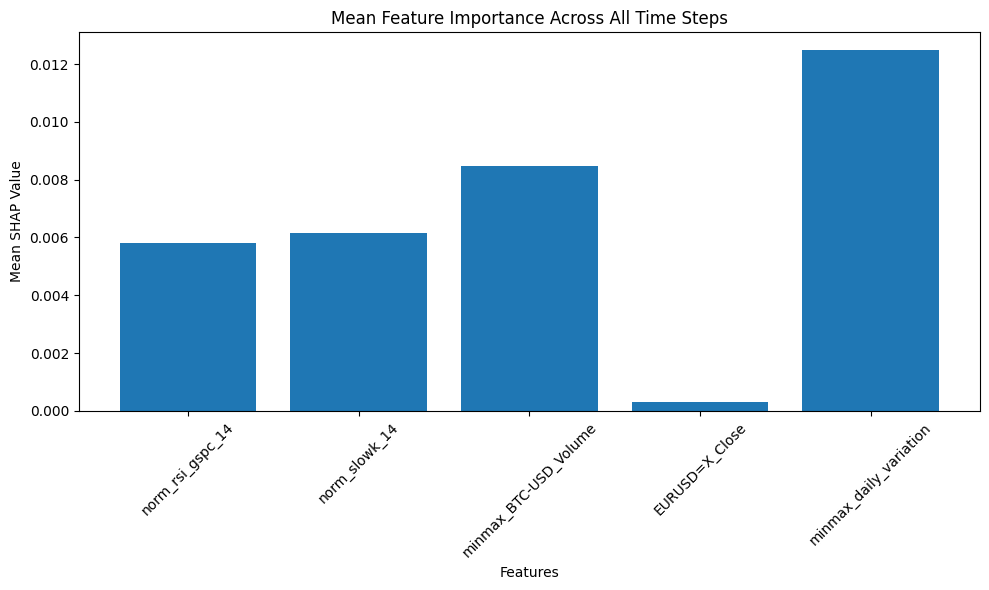

1


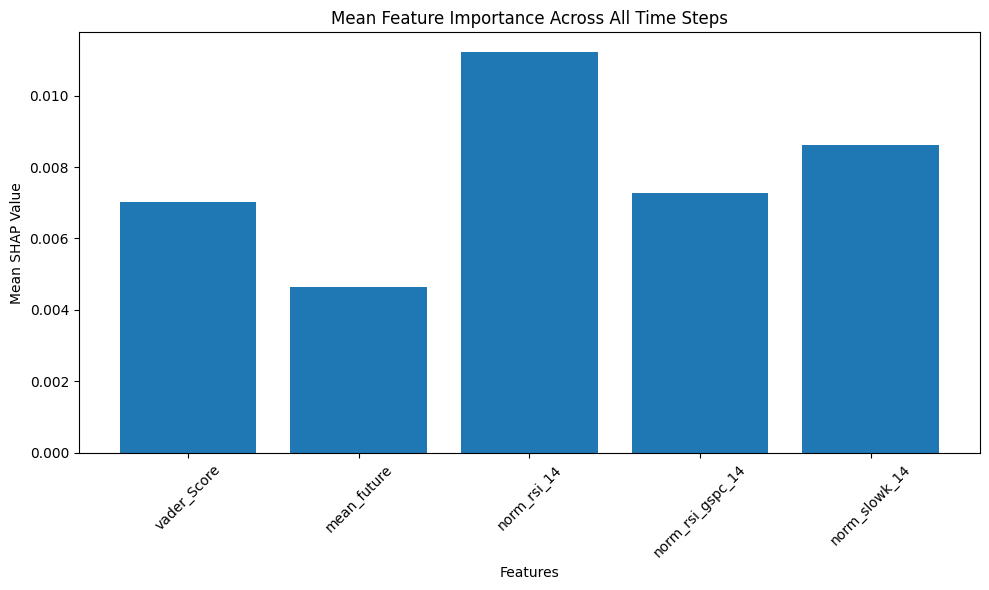

59


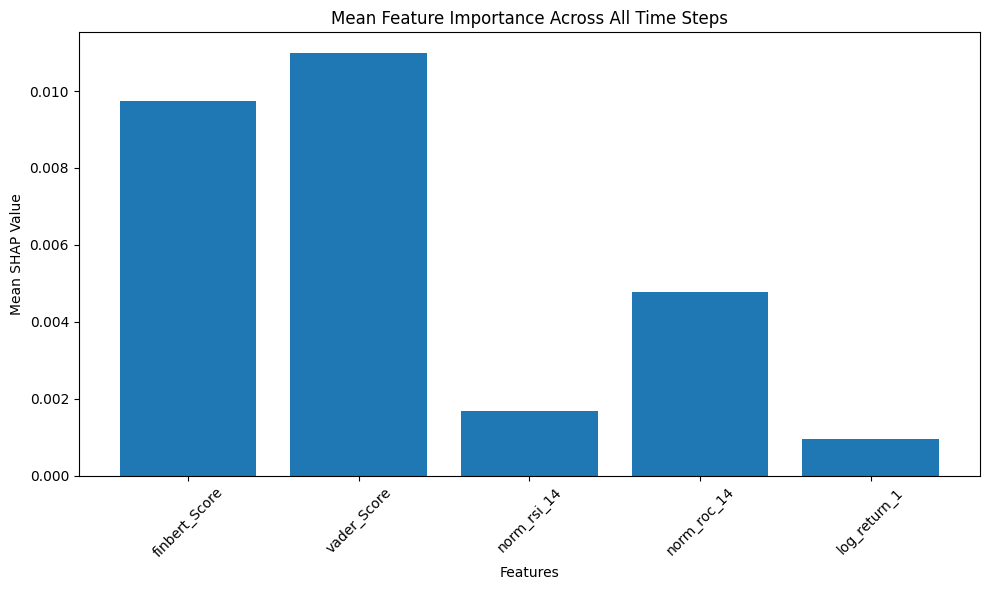

29


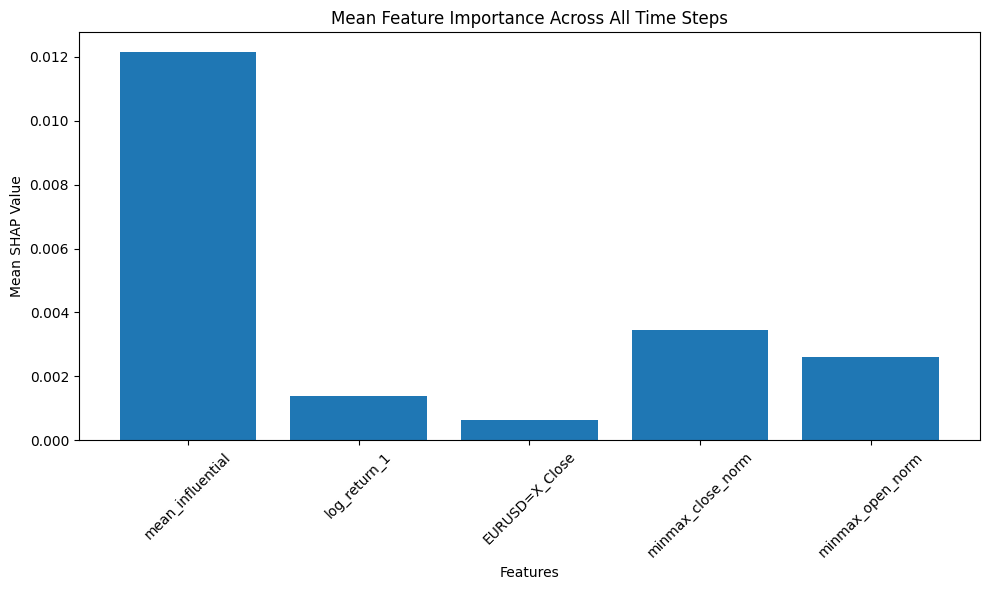

42


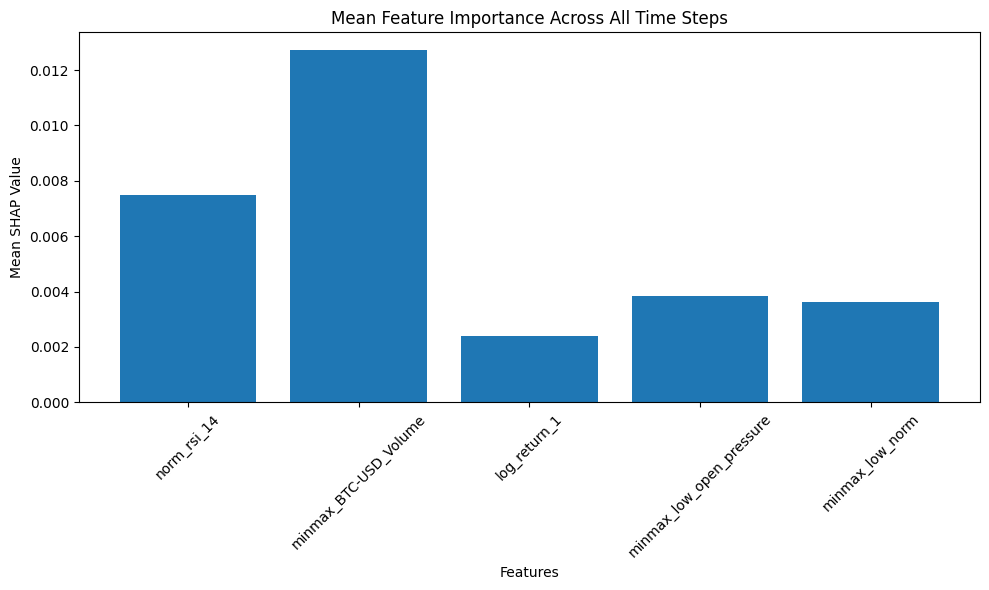

75


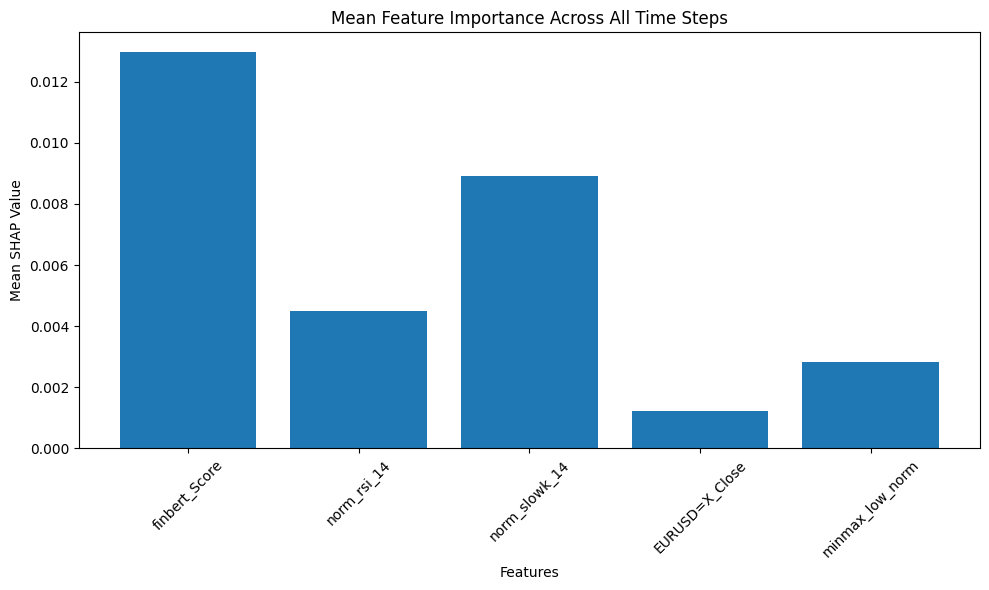

64


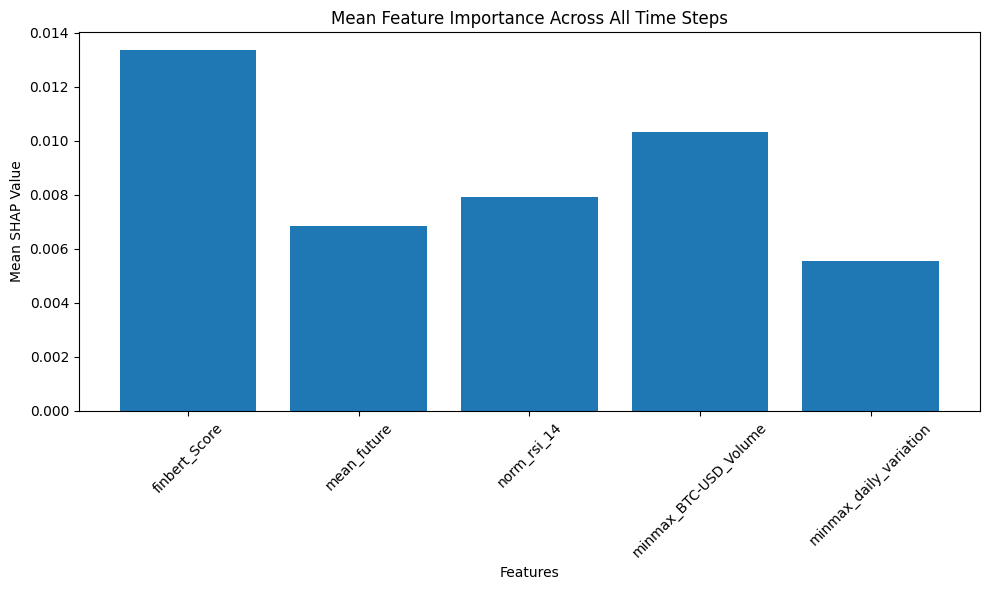

56


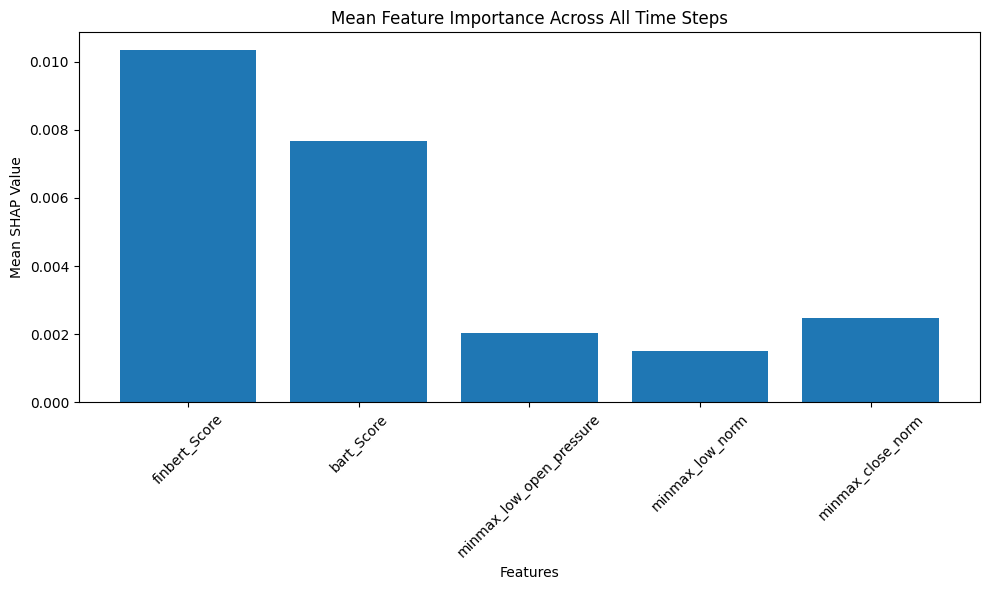

73


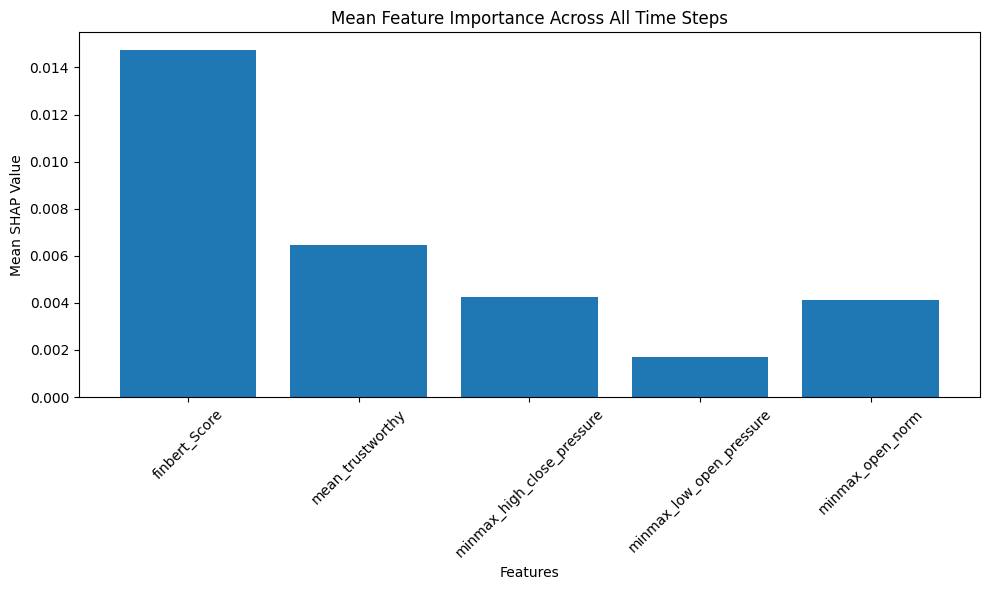

61


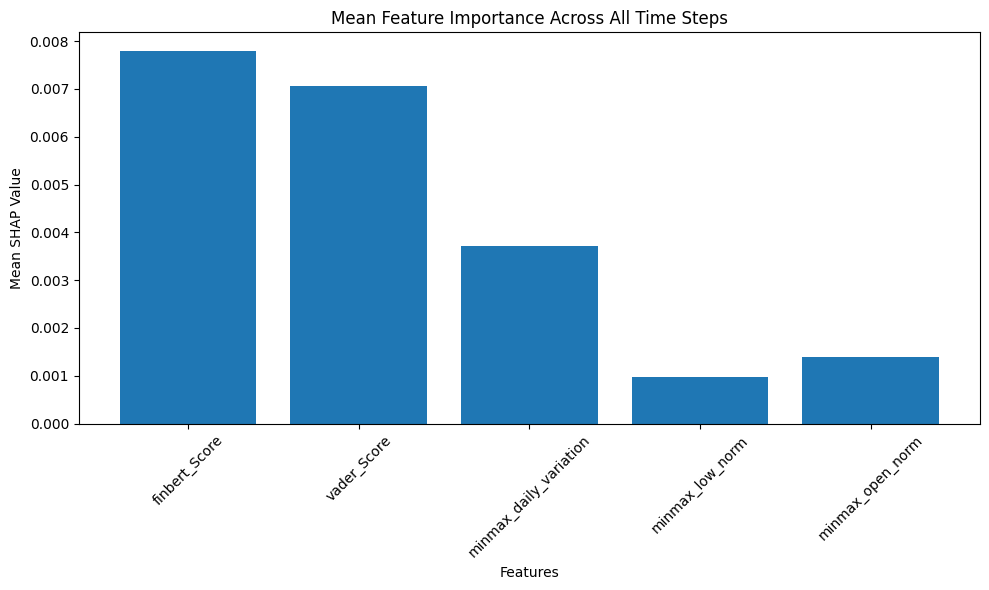

In [58]:
#max across windows
for index, row in top_10_df.iterrows():
    print(index)
    shap_values = row['aggregated_shap']
    feature_names = row['cols_used']
    plot_mean_feature_importance(shap_values, feature_names,True)

45


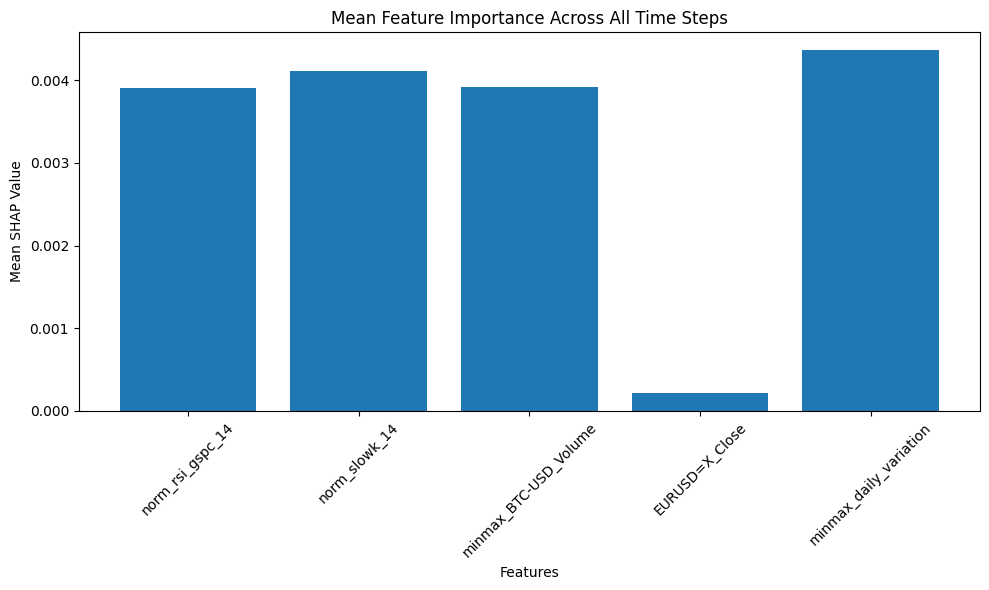

1


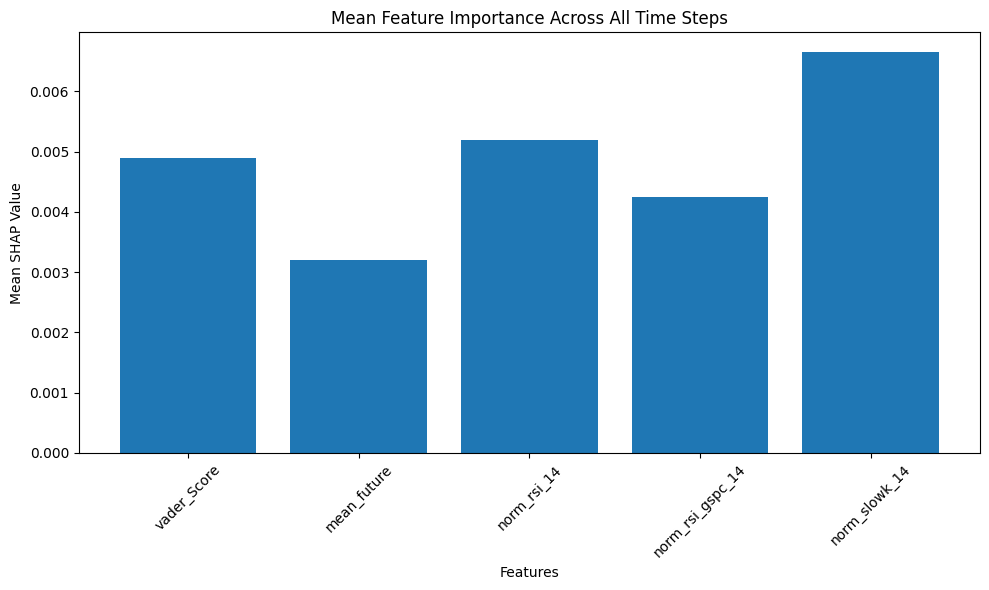

59


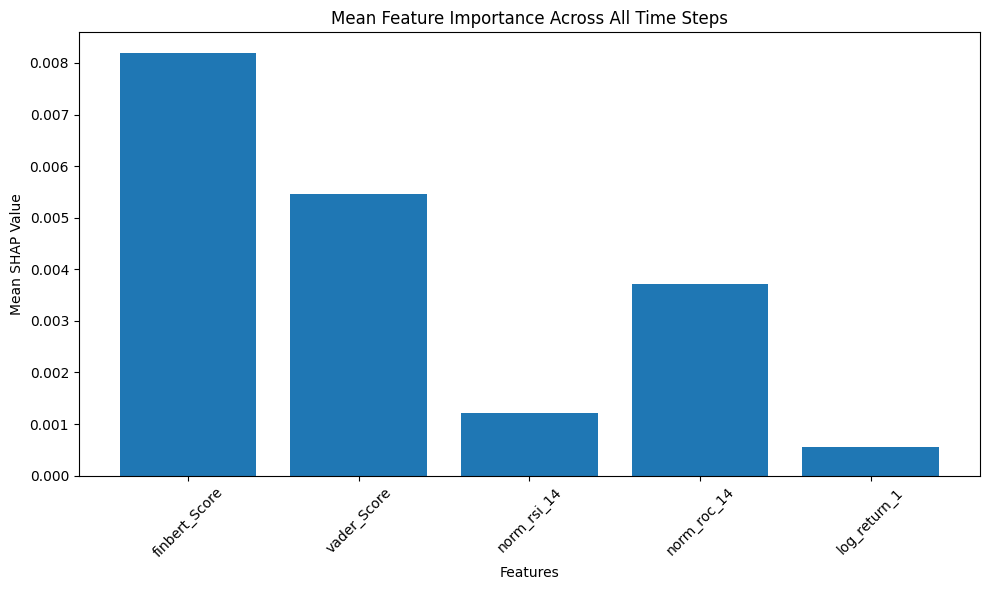

29


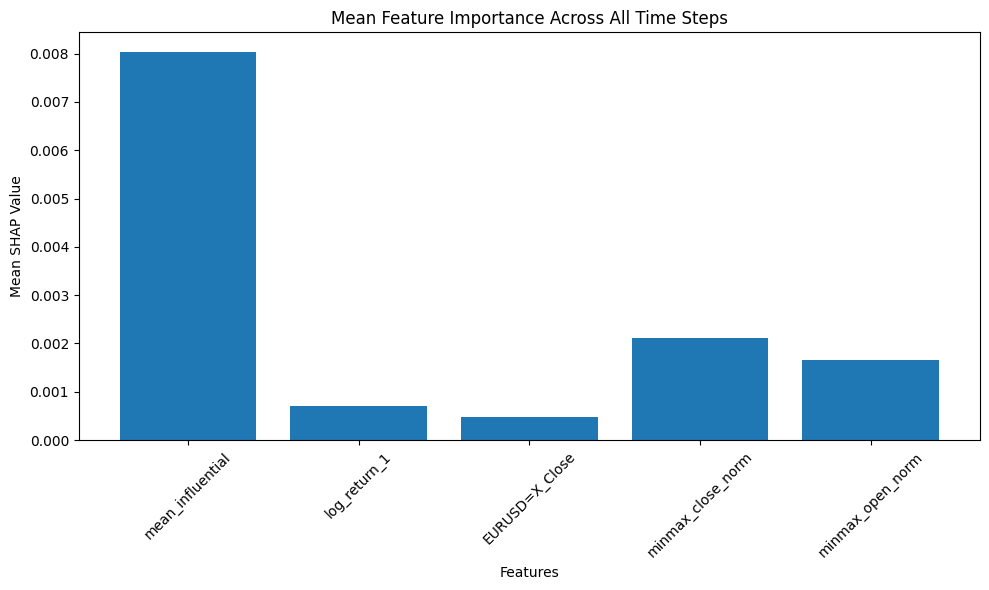

42


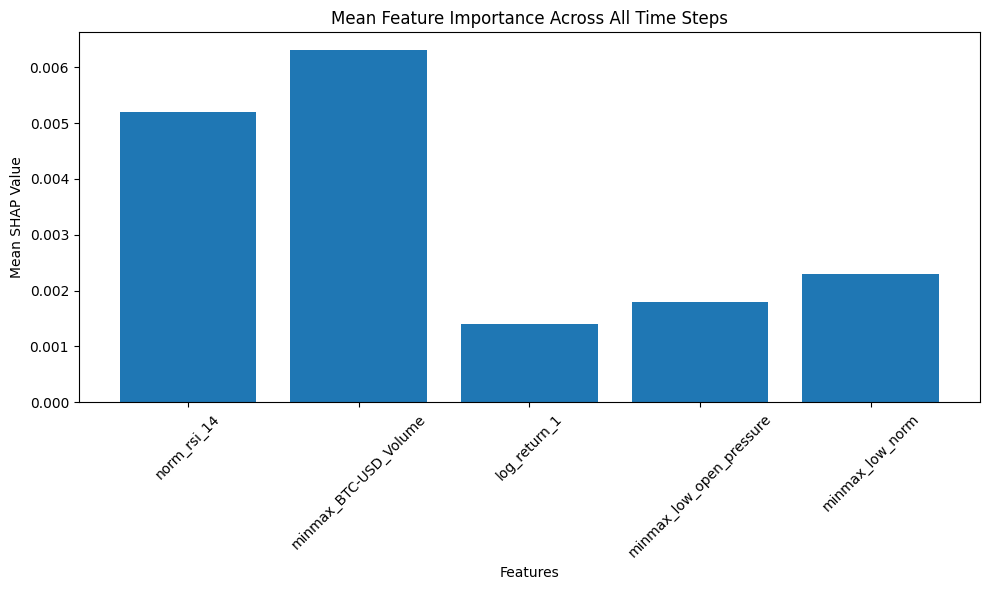

75


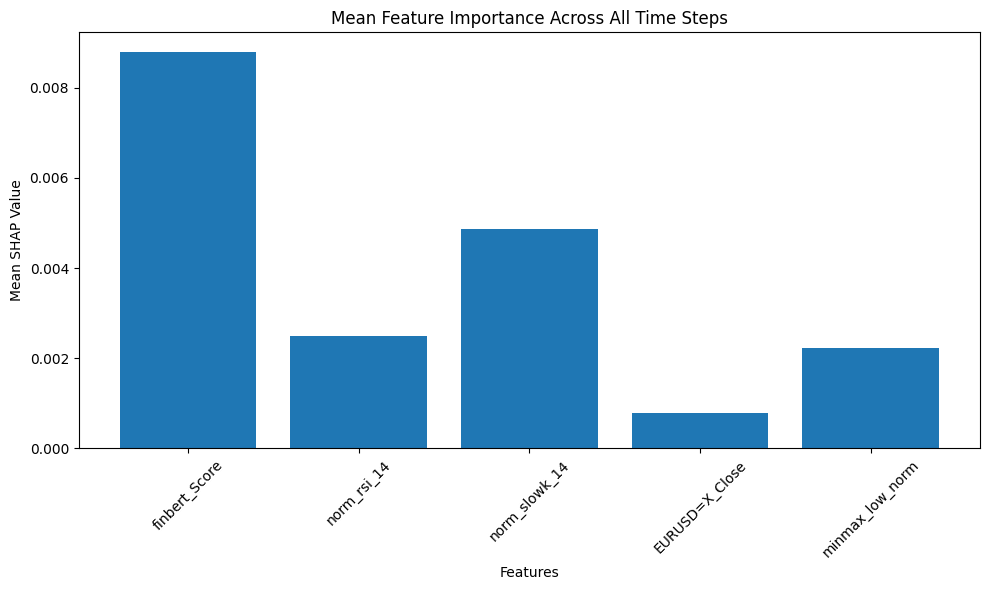

64


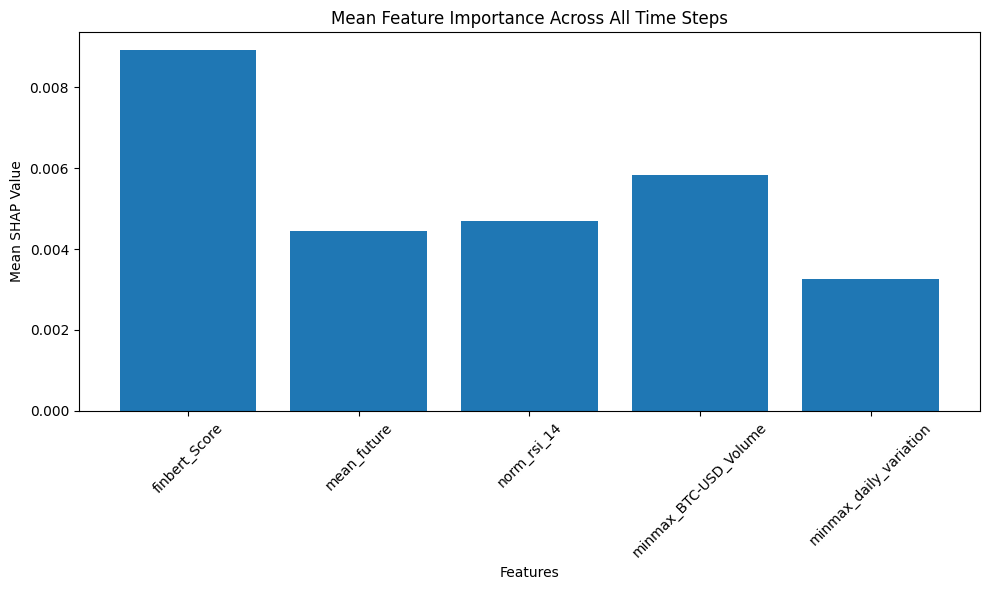

56


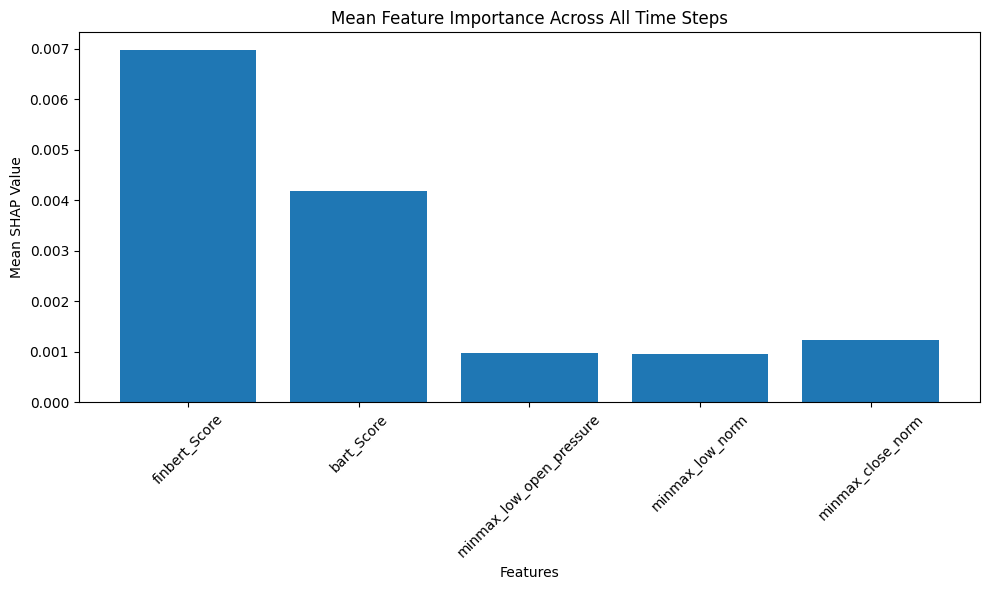

73


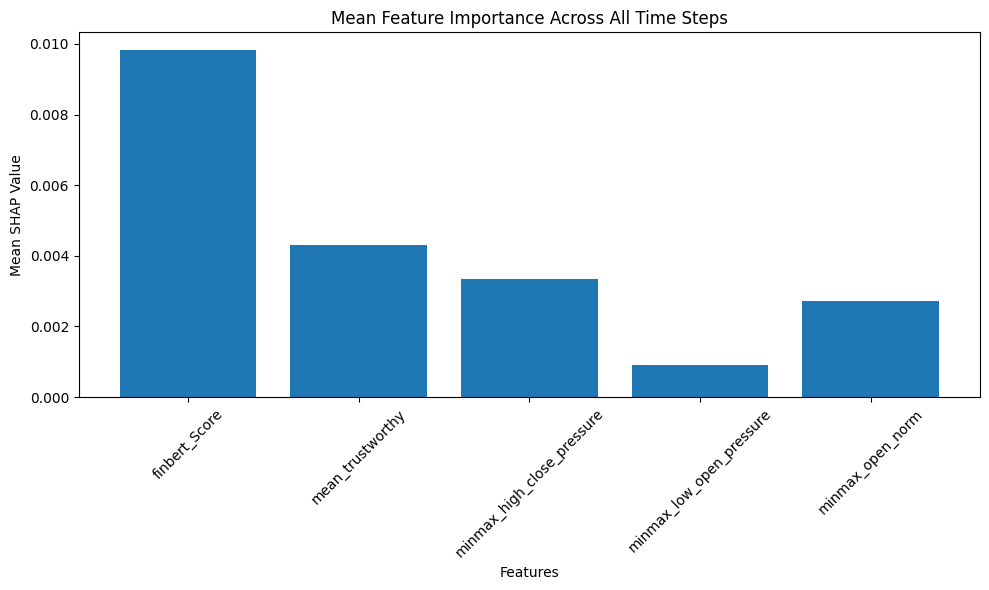

61


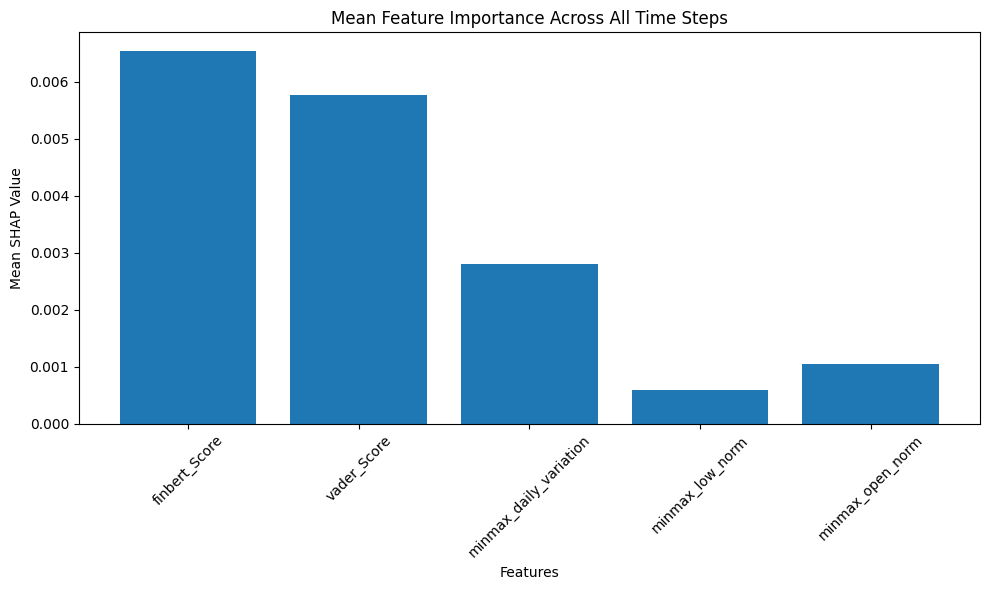

In [59]:
#mean across windows
for index, row in top_10_df.iterrows():
    print(index)
    shap_values = row['aggregated_shap']
    feature_names = row['cols_used']
    plot_mean_feature_importance(shap_values, feature_names)

### Przykładowy model

In [68]:
window_size = 14
target_cols = ['target_7']
cols_used = {'norm_rsi_gspc_14',
 'norm_slowk_14',
 'minmax_BTC-USD_Volume',
 'EURUSD=X_Close',
 'minmax_daily_variation'}
X,y = window_dataset(train_set[list(cols_used)+target_cols],  target_cols[0], window_size)
X_val, y_val = window_dataset(val_set[list(cols_used)+target_cols], target_cols[0], window_size)

#model,history = make_model(X,y,100,lstm_units=32)
model, history = make_model_better(X, y, X_val, y_val, n_epochs=500, lstm_units=32,
                              dense_units=8, patience=100)

Train on 932 samples, validate on 42 samples
Epoch 1/500
932/932 [==============================] - 2s 2ms/sample - loss: 0.0129 - val_loss: 0.0026
Epoch 2/500
932/932 [==============================] - 1s 714us/sample - loss: 0.0090 - val_loss: 0.0012
Epoch 3/500
932/932 [==============================] - 1s 736us/sample - loss: 0.0089 - val_loss: 0.0018
Epoch 4/500
932/932 [==============================] - 1s 716us/sample - loss: 0.0090 - val_loss: 0.0017
Epoch 5/500
932/932 [==============================] - 1s 754us/sample - loss: 0.0092 - val_loss: 0.0013
Epoch 6/500
932/932 [==============================] - 1s 791us/sample - loss: 0.0086 - val_loss: 0.0012
Epoch 7/500
932/932 [==============================] - 1s 546us/sample - loss: 0.0085 - val_loss: 0.0014
Epoch 8/500
932/932 [==============================] - 1s 538us/sample - loss: 0.0091 - val_loss: 0.0013
Epoch 9/500
932/932 [==============================] - 1s 542us/sample - loss: 0.0086 - val_loss: 0.0015
Epoch 10/500

#### wyniki

In [69]:
model = load_model('best_model.h5')

In [70]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X)

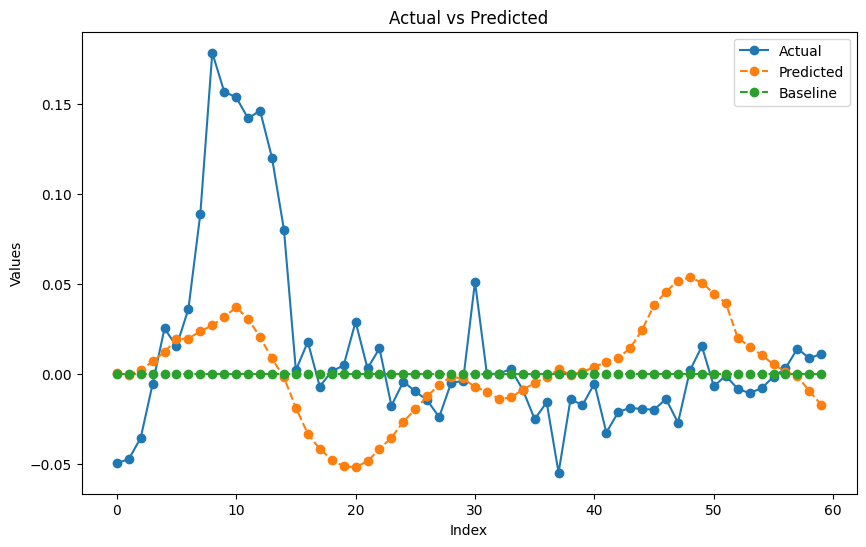

In [71]:
k=-60
plot_actual_vs_predicted(y[k:], y_pred_train[k:], y_base0_train[k:])

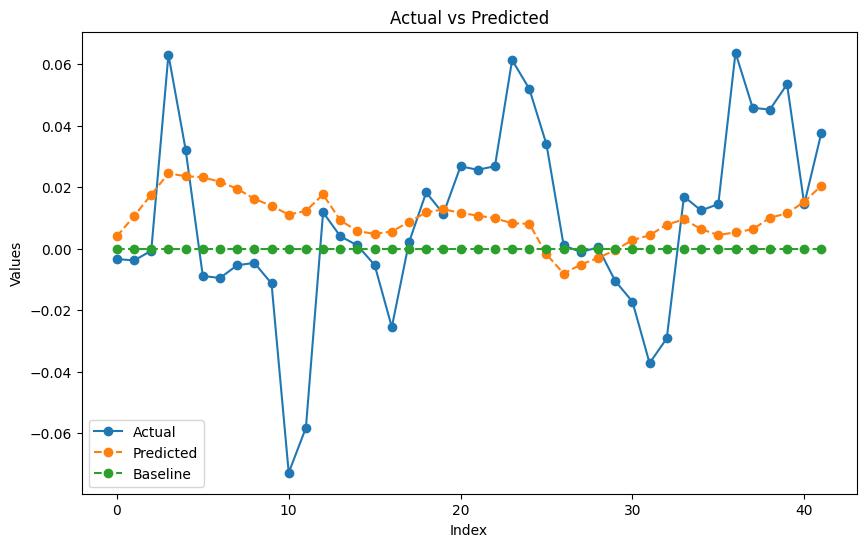

In [72]:
plot_actual_vs_predicted(y_val, y_pred_val, y_base0_val)

In [73]:
print('Model')
print(calculate_metrics(y, y_pred_train, np.array([1]), np.array([1]), y_val, y_pred_val))
print('-----')
print('Baseline 0')
print(calculate_metrics(y, y_base0_train, np.array([1]), np.array([1]), y_val, y_base0_val))
print('-----')
print('Baseline Prev')
print(calculate_metrics(y, y_base_train, np.array([1]), np.array([1]), y_val, y_base_val))


Model
                 MAE       MSE      RMSE  R2 Score        MAPE      MASE
Train       0.065099  0.007728  0.087908  0.107874  381.522401  1.815129
Test        0.000000  0.000000  0.000000       NaN    0.000000  0.000000
Validation  0.023064  0.000905  0.030088 -0.006157  290.241788  0.643076
-----
Baseline 0
                 MAE       MSE      RMSE  R2 Score   MAPE      MASE
Train       0.066913  0.008664  0.093081 -0.000226  100.0  1.865707
Test        0.000000  0.000000  0.000000       NaN    0.0  0.000000
Validation  0.023349  0.000978  0.031273 -0.086958  100.0  0.651022
-----
Baseline Prev
                 MAE       MSE      RMSE  R2 Score         MAPE      MASE
Train       0.084941  0.012154  0.110246 -0.403127  1261.435456  2.368370
Test        0.000000  0.000000  0.000000       NaN     0.000000  0.000000
Validation  0.039716  0.002424  0.049235 -1.694145  1103.995013  1.107376


In [74]:
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X_val)

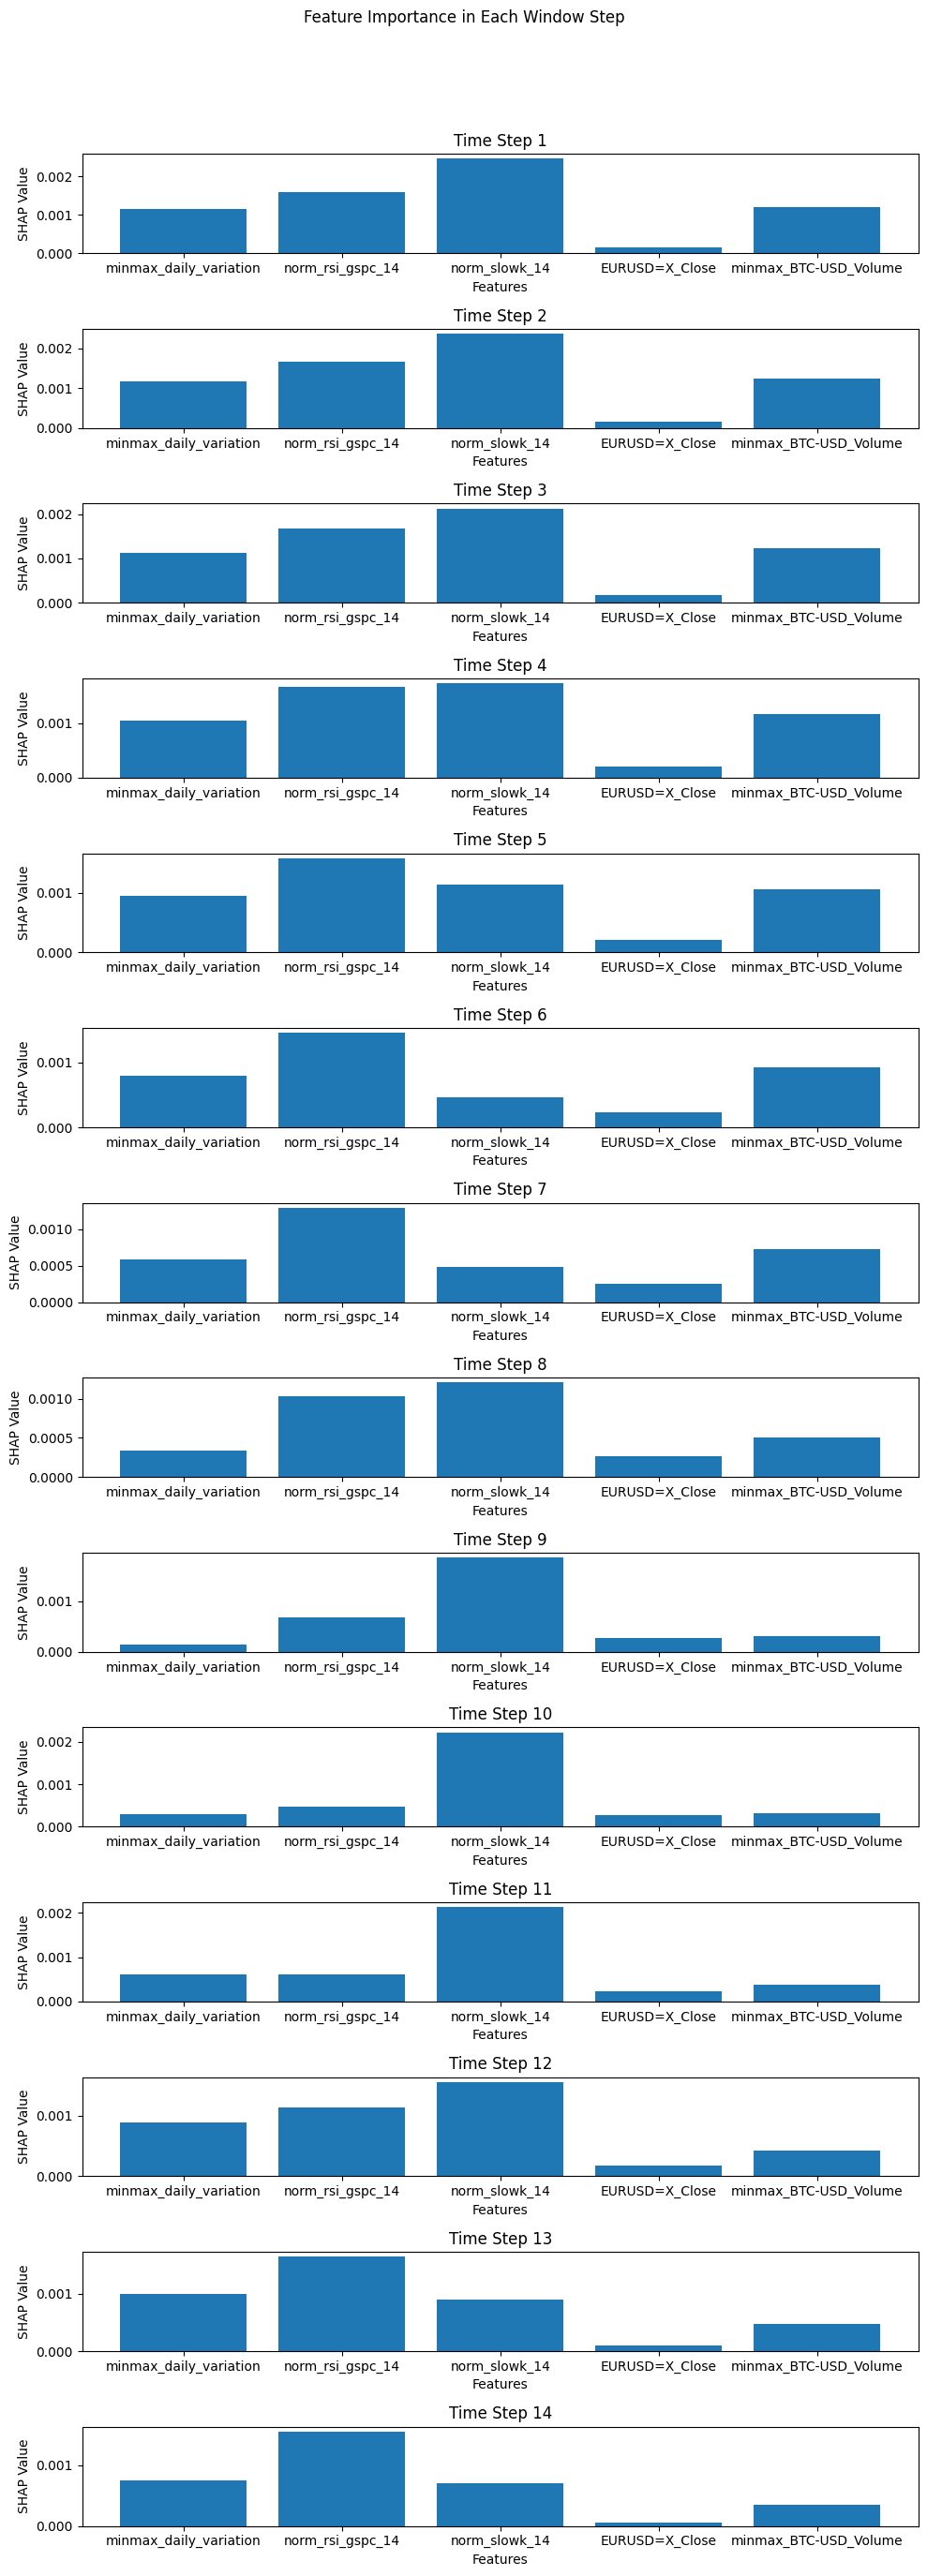

In [75]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(shap_values, feature_names,window_size):
    """
    Plot the importance of each feature at each step in the window.

    :param shap_values: A 3D array of SHAP values with shape (samples, window_size, num_features).
    :param feature_names: List of feature names.
    """
    # Aggregate SHAP values across all samples
    aggregated_shap = np.mean(np.abs(shap_values[0]), axis=0)

    # Create a plot for each time step in the window
    window_size = aggregated_shap.shape[0]
    num_features = aggregated_shap.shape[1]

    # Set up the plot
    fig, axs = plt.subplots(window_size, 1, figsize=(10, window_size * 2))
    fig.suptitle('Feature Importance in Each Window Step')

    # Plot each time step
    for i in range(window_size):
        axs[i].bar(feature_names, aggregated_shap[i, :])
        axs[i].set_title(f'Time Step {i+1}')
        axs[i].set_ylabel('SHAP Value')
        axs[i].set_xlabel('Features')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
feature_names = list(cols_used)
plot_feature_importance(shap_values, feature_names,window_size)
